<center>
<h1>Mustererkennung und Machine Learning</h1>

<h3> Wintersemester 2017/2018, 4th Exercise Sheet</h3>
<h4>Konstantin Jaehne, Luis Herrmann; Dozent: Raúl Rojas</h4>

<hr style='height:1px'>
</center>

First of all, we define the functions to load the data form the specified files. Please sure to change the path for the training files for the respective path.

In [264]:
%matplotlib inline
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def readfile(filename):
    """Opens file with given filename and reads in data line after line into a numpy array"""
    data = []
    f = open(filename)
    for line in f:
        ls = line.split(',')
        digit = int(float(ls[57]))
        matrix = np.array([float(val) for val in ls[:57]])
        data.append((digit,matrix))
    f.close()
    return(data)
    
data = readfile('E:/Users/Tanui/Documents/Uni/info/MachineLearning/spambase.data')
spam = []
nospam = []
for sample in data:
    if(sample[0] == 1):
        spam.append(sample[1].reshape([57,1]))
    elif(sample[0] == 0):
        nospam.append(sample[1].reshape([57,1]))
print('Data contains ' + str(len(spam)) + ' data points of spam and ' + str(len(nospam)) + ' points of non-spam.')
train = (nospam[:int(0.8 * len(nospam))], spam[:int(0.8 * len(spam))])
test = (nospam[int(0.8 * len(nospam)):], spam[int(0.8 * len(spam)):])

Data contains 1813 data points of spam and 2788 points of non-spam.


Now we shall implement a classifier using  a gaussian multivariate distribution. For such a distribution, the probability is given by:

<center>$p(\vec{x}) = \frac{1}{\sqrt{(2\pi)^{n} \det(\Sigma)}} \exp\left(-\frac{1}{2} (\vec{x} - \vec{\mu})^T \Sigma^{-1} (\vec{x} - \vec{\mu}) \right)$</center>

Where $n$ is the dimension of the multivariate distribution, $\Sigma$ is the so-called covariance matrix and $\vec{\mu}$ the mean vector. Given a set of training vectors $\vec{v_1}, \vec{v_2}, ... \vec{v_N}$, the latter are determined as:

<center>$\Sigma := \frac{1}{N}\sum_i^N (\vec{x}_i - \vec{\mu})(\vec{x}_i - \vec{\mu})^T \qquad \vec{\mu} := \frac{1}{N} \sum_i^N \vec{x}_i$</center>

So the idea is the following: Use a set of training vectors to compute a Gaussian distribution for each digit class describing the probability that a vector $\vec{x}$ belongs to that class.
After that, given a vector $\vec{x}$ that we want to assign to one of the classes of our respective classifier, calculate the probability $p_d(\vec{x})$ for all digit classes $d$ considered by the classifier and assign $\vec{x}$ to the digit class $d$ for which $p_d(\vec{x})$ is greatest.

However, rather than calculating the actual probabilities, we are going to use Fisher's discriminant to create a binary classifier. That is, we are going to find a vector $\alpha$ such that:

<center>$S(\vec{\alpha}) := \frac{|\vec{\mu}_1\cdot \vec{\alpha} - \vec{\mu}_2\cdot\vec{\alpha}|^2}{\vec{\alpha}^T(\Sigma_1+\Sigma_2)\vec{\alpha}}$</center>

is minimized. Here, $\Sigma_1$ and $\Sigma_2$ are the respective covariante matrices of the two classes and $\vec{\mu}_1$ and $\vec{\mu}_2$ are the respective mean vectors. One can derive that $S(\vec{\alpha})$ is indeed minimized for:

<center>$(\Sigma_1+\Sigma_2) \vec{\alpha} = (\vec{\mu}_1 - \vec{\mu}_2)$</center>

So whenever we want to classify a vector $\vec{x}$, we will first project it onto $\vec{\alpha}$ and then calculate the probability.

In [255]:
class FisherClassifier:
    def __init__(self, data=None):
        if(data != None):
            self.digits = [0,1]
            self.train(data)
        
    def train(self, trainData):
        """
        Expects a list of two lists [l1, l2], where l1 and l2 are lists of vectors belonging to class 1
        and 2, respectively.
        Trains by calculating the parameters of the corresponding multivariate gaussian distributions p_c(x)
        and the projection vector of the Fisher discriminant.
        """
        #Calculate the parameters of p_c(x) for each digit class 
        self.params = {}
        SigmaSum = np.zeros([57,57])
        for i in range(2):
            mu = sum(trainData[i])/len(trainData[i])
            sdev = np.sqrt(sum([np.dot(np.transpose(x-mu),x-mu) for x in trainData[i]])/len(trainData[i]))[0][0]
            Sigma = sum([np.dot(x-mu,np.transpose(x-mu)) for x in trainData[i]])/len(trainData[i])
            SigmaSum += Sigma
            fac = 1e-1
            step = fac*np.identity(57)
            while(np.linalg.det(Sigma) == 0):
                Sigma += step
            norm = len(trainData[i])/np.sqrt(np.linalg.det(2*np.pi*Sigma))
            Sigmai = -1/2*np.linalg.inv(Sigma)
            self.params[i] = [norm, mu, Sigmai]
        #Calculate vector alpha, norm it, and calculate projection operator alpha * alpha^T
        self.alpha = np.linalg.solve(SigmaSum, self.params[1][1] - self.params[0][1])
        self.alpha = self.alpha/np.sqrt(sum(map(lambda x: x**2, self.alpha)))
        self.P = np.dot(self.alpha, np.transpose(self.alpha))
        #Transform inverse covariance matrix
        for i in range(2):
            self.params[i][2] = np.dot(self.P, np.dot(self.params[i][2], self.P))
        print('Completed training on ' + str(sum([len(trainData[k]) for k in range(2)])) + ' data samples.')
    
    def gaussian(self, digit,x):            
        norm, mu, Sigmai = self.params[digit]
        return norm*np.exp(np.dot((x-mu).reshape(57),np.dot(Sigmai,x-mu).reshape(57)))
    
    def classify(self, data):
        """'
        Expects a vector of dimension 57.
        Returns digit, for which the probability is greatest assuming a gaussian multivariate distribution
        """ 
        return max(range(2), key=lambda x: self.gaussian(x, data))
    
    def plot(self, xrange):
        mu1, mu2 = self.params[0][1].reshape(57), self.params[1][1].reshape(57)
        mu1_a = np.dot(mu1,self.alpha.reshape(57))
        mu2_a = np.dot(mu2,self.alpha.reshape(57))
        print('Projected mean vectors:' + str(mu1_a) + ' and ' + str(mu2_a))
        fig, ax1 = plt.subplots()
        ax2 = ax1.twinx()
        ax1.plot(xrange, list(map(lambda x: self.gaussian(0,x*self.alpha), xrange)), 'b-')
        ax2.plot(xrange, list(map(lambda x: self.gaussian(1,x*self.alpha), xrange)), 'r-')

With the classifier defined, we derive a binary classifier with the training set of data:

In [256]:
C = FisherClassifier(train)

Completed training on 3680 data samples.


Finally, we define a function runtest to run the <font color='blue'>classifer()</font>-functions of the respective classifier on the test data and obtain the confusion matrices and error rates

In [257]:
from IPython.display import display, HTML
def runtest(C):
    confusionMat = np.zeros([len(C.digits), len(C.digits)], dtype=int)
    for sample in test[0]:
        confusionMat[0, C.classify(sample)] += 1
    for sample in test[1]:
        confusionMat[1, C.classify(sample)] += 1
    print('-The confusion matrix is given by:')
    html = pd.DataFrame(confusionMat,index=[str(x) for x in C.digits], columns=[str(x) for x in C.digits]).to_html()
    display(HTML(html))
    print('-The error rate is: ' + str(1-sum(np.diag(confusionMat))/(len(test[0]) + len(test[1]))) + '\n')

In [258]:
runtest(C)

-The confusion matrix is given by:


,0,1
0,476,82
1,85,278


-The error rate is: 0.181324647123



Projected mean vectors:-0.127520803163 and 0.971369753527


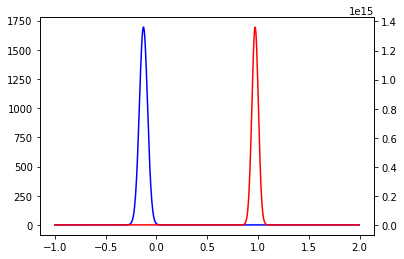

In [259]:
C.plot(np.arange(-1,2,1/200))

The vector $\vec{\alpha}$ can also be used the derive information on what features are most important for classification. Since the vector  is chosen such that 'difference' of the classes is maximal, the vector tells us that the features associated with components of the vector that have larger absolute values are more important.
We can provide a useful intuition to understand this concept. Consider a normed vector, where all components' absolute values are small and that specific component's absolute value is close to 1. The higher that absolute value is, the more 'similar' the vector will be to the canonical unit vector of that component. A canonical unit vector would mean that classification can be performed by projecting onto that feature's component, so all other components would not contribute to classification.

For the $\vec{\alpha}$ calculated for this problem, the maximal absolute values are obtained in the order of magnitude of 1e-01.

In [260]:
C.alpha

array([[ -1.13651666e-01],
       [ -2.96656593e-02],
       [  7.23313309e-02],
       [  1.52518965e-02],
       [  1.21368541e-01],
       [  1.78730934e-01],
       [  3.00613042e-01],
       [  1.53240292e-01],
       [  7.43085186e-02],
       [  1.86233379e-02],
       [  3.35839240e-02],
       [ -8.35732395e-02],
       [  3.26095253e-02],
       [ -2.21798764e-02],
       [  8.06544558e-03],
       [  1.11164124e-01],
       [  2.71139060e-02],
       [  1.27131697e-01],
       [  6.01864571e-02],
       [  8.34007734e-02],
       [  9.98199559e-02],
       [  7.78618478e-02],
       [  2.63536332e-01],
       [  1.91657502e-01],
       [ -4.83364004e-02],
       [ -4.81462321e-02],
       [ -2.83891396e-02],
       [ -5.90271755e-02],
       [ -3.70103952e-03],
       [ -7.77074030e-02],
       [ -3.44118171e-02],
       [  2.90246757e-01],
       [ -9.98748201e-02],
       [ -1.26319900e-01],
       [ -5.81973288e-02],
       [  2.25038261e-02],
       [ -5.76686421e-02],
 